In [1]:
import pandas as pd
import json
import numpy as np

import joblib

pd.set_option('display.max_colwidth',  None)

with open('result.json') as f:
    data = json.load(f)

df = pd.DataFrame(data)

df.fillna(0, inplace=True)
df = df.apply(lambda series: pd.to_numeric(series, errors='coerce'))
df = df.dropna()
df.head()

,Epidian 6D,Araldite GY260,Araldite GY250CH,CHS-520 (*CHS-530),CHS-525,CHS-590,Epidian 5,Epidian 6,Epilox AF 18-50,AH-24/Grilonit epoxide 8,...,trisDMP,DCH-99,MXDA,Ethacure 100,nonilfenol,etanol,AHEW,Fazékidő (min),Szakítószilárdság [MPa],Szakadási nyúlás [%]
0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,24.400000,46.0,82.57,5.58
1,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,27.685325,53.0,41.72,3.35
2,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,31.228669,34.0,56.60,4.76
3,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,35.812133,28.0,61.23,5.59
4,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,27.685325,61.0,41.13,3.67


In [51]:
colnames = ['Epidian 6D', 'Araldite GY260', 'Araldite GY250CH', 'CHS-520 (*CHS-530)', 'CHS-525', 'CHS-590', 'Epidian 5', 'Epidian 6', 'Epilox AF 18-50', 'AH-24/Grilonit epoxide 8', 'Epidian 011', 'RD-3', 'RD-20', 'IPOX ER 1010', 'IPOX ER 1016', 'Cardura E', 'Benzilalkohol', 'EEW', 'TETA/         TEPA (a)', 'IPDA', 'Jeffamine D230', 'Jeffamine D230 + Epilox1700', 'Jeffamine D230 + Epilox1700 (addukt 2)', 'IPDA+1010 addukt', 'TEA/ ', 'Dytek A-MPMD/APU-2**', 'APU-4', 'trisDMP', 'DCH-99', 'MXDA', 'Ethacure 100', 'nonilfenol', 'etanol', 'AHEW', 'Fazékidő (min)', 'Szakítószilárdság [MPa]', 'Szakadási nyúlás [%]']
y_colnames = colnames[:-3]

In [14]:
df.iloc[:, 19]

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
361    0.0
365    0.0
366    0.0
367    0.0
368    0.0
Name: IPDA, Length: 361, dtype: float64

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd

X = df.iloc[:, -3:]

# a list to store results
results = []

# dictionaries to store models and scalers
models = {}
scalers = {}

# loop over the column indices
for i in range(df.shape[1] - 3):
    # get the column name
    col_name = df.columns[i]
    
    # create the target vector
    y = df.iloc[:, i]

    # split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # prepare and store the standard scaler
    ss = StandardScaler().fit(X_train)
    scalers[col_name] = ss

    # transform the data
    X_train = ss.transform(X_train)
    X_test = ss.transform(X_test)


    # Define the hyperparameter grid
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_features': ['auto', 'sqrt'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    }

    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = RandomForestRegressor(), param_grid = param_grid, 
                            cv = 5, scoring='neg_mean_squared_error', n_jobs = -1, verbose = 2)

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    # Retrieve the best model
    best_rf_model = grid_search.best_estimator_
    # Print the best parameters
    best_params = grid_search.best_params_
    print(f'Best parameters for [{col_name}]:', best_params)


    # Create a RandomForestRegressor object
    # rf_model = RandomForestRegressor()
    rf_model = best_rf_model

    # Train the model
    rf_model.fit(X_train, y_train)

    # Make predictions on the training set
    y_train_pred = rf_model.predict(X_train)

    # Evaluate the model on the training set
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)

    # Make predictions on the test set
    y_test_pred = rf_model.predict(X_test)

    # Evaluate the model on the test set
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Store results
    results.append({
        'column': col_name,
        'train_rmse': train_rmse,
        'train_r2': train_r2,
        'train_mae': train_mae,
        'test_rmse': test_rmse,
        'test_r2': test_r2,
        'test_mae': test_mae,
        'model': rf_model,
        'model_params': best_params
    })
    
    # Store model
    models[col_name] = rf_model

# create a DataFrame from the results
results_df = pd.DataFrame(results)

print(results_df)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50}
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50}
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Fitting 5 folds for each of 216 candidates, to

In [16]:
print(scalers)

{'Epidian 6D': StandardScaler(), 'Araldite GY260': StandardScaler(), 'Araldite GY250CH': StandardScaler(), 'CHS-520 (*CHS-530)': StandardScaler(), 'CHS-525': StandardScaler(), 'CHS-590': StandardScaler(), 'Epidian 5': StandardScaler(), 'Epidian 6': StandardScaler(), 'Epilox AF 18-50': StandardScaler(), 'AH-24/Grilonit epoxide 8': StandardScaler(), 'Epidian 011': StandardScaler(), 'RD-3': StandardScaler(), 'RD-20': StandardScaler(), 'IPOX ER 1010': StandardScaler(), 'IPOX ER 1016': StandardScaler(), 'Cardura E': StandardScaler(), 'Benzilalkohol': StandardScaler(), 'EEW': StandardScaler(), 'TETA/         TEPA (a)': StandardScaler(), 'IPDA': StandardScaler(), 'Jeffamine D230': StandardScaler(), 'Jeffamine D230 + Epilox1700': StandardScaler(), 'Jeffamine D230 + Epilox1700 (addukt 2)': StandardScaler(), 'IPDA+1010 addukt': StandardScaler(), 'TEA/ ': StandardScaler(), 'Dytek A-MPMD/APU-2**': StandardScaler(), 'APU-4': StandardScaler(), 'trisDMP': StandardScaler(), 'DCH-99': StandardScaler(),

In [11]:
all_models_1 = results_df

In [47]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler

# Get your inputs and outputs
X = df.iloc[:, -3:]
y = df.iloc[:, :-3]

# Split the original data into training and testing sets
X_train_original, X_test_original, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a placeholder for your new inputs to the Neural Network
X_train_nn = np.zeros((X_train_original.shape[0], y.shape[1]))
X_test_nn = np.zeros((X_test_original.shape[0], y.shape[1]))
y_nn_train = y_train.to_numpy().copy() 
y_nn_test = y_test.to_numpy().copy() 

# Define number of splits
n_splits = 5

# Prepare the cross-validation procedure
cv = KFold(n_splits=n_splits, random_state=42, shuffle=True)

# Generate the new training set for the Neural Network
for i in range(y.shape[1]):
    # Get the model and scaler for this output column
    model = models[y.columns[i]]
    scaler = scalers[y.columns[i]]
    
    # Perform k-fold cross-validation on the original training set
    for train_index, val_index in cv.split(X_train_original):
        X_train, X_val = X_train_original.iloc[train_index], X_train_original.iloc[val_index]

        # y_train = y_train.iloc[train_index, i]
        y_train_subset = y_train.iloc[train_index].iloc[:, i]


        # Scale the inputs
        X_train_scaled = scaler.transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        # Train the model
        model.fit(X_train_scaled, y_train_subset)
        
        # Get predictions for the validation set and assign to the appropriate slice of X_train_nn
        X_train_nn[val_index, i] = model.predict(X_val_scaled)
        
    # Now that the model is trained on all of the original training set, use it to generate the test set for the Neural Network
    X_test_scaled = scaler.transform(X_test_original)
    X_test_nn[:, i] = model.predict(X_test_scaled)

# Now you have new training and test sets for your Neural Network, you can proceed with training it as before
# e.g., model.fit(X_train_nn, y_nn_train, ...), model.evaluate(X_test_nn, y_nn_test, ...)


In [107]:
scaler_nn = StandardScaler().fit(X_train_nn)
X_train_nn = scaler_nn.transform(X_train_nn)

In [34]:
print(X_train_original.shape, X_test_original.shape, y_train.shape, y_test.shape)

(288, 3) (73, 3) (230,) (73, 34)


In [110]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 34)                1190      
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 34)                0         
                                                                 
 batch_normalization_18 (Bat  (None, 34)               136       
 chNormalization)                                                
                                                                 
 dense_22 (Dense)            (None, 16)                560       
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 16)                0         
                                                                 
 batch_normalization_19 (Bat  (None, 16)               64        
 chNormalization)                                     

In [174]:
model_save.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 3)                 105       
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 3)                 0         
                                                                 
 batch_normalization_12 (Bat  (None, 3)                12        
 chNormalization)                                                
                                                                 
 dense_15 (Dense)            (None, 6)                 24        
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 6)                 0         
                                                                 
 batch_normalization_13 (Bat  (None, 6)                24        
 chNormalization)                                     

In [175]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LeakyReLU


model = keras.Sequential([
    keras.layers.Dense(X_train_nn.shape[1]),
    LeakyReLU(alpha=0.1),
    keras.layers.BatchNormalization(),


    keras.layers.Dense(X_train_nn.shape[1]*2),
    LeakyReLU(alpha=0.1),
    keras.layers.BatchNormalization(),

    
    keras.layers.Dense(X_train_nn.shape[1]*4),
    LeakyReLU(alpha=0.1),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),

    keras.layers.Dense(X_train_nn.shape[1]*8),
    LeakyReLU(alpha=0.1),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),


    keras.layers.Dense(X_train_nn.shape[1]*16),
    LeakyReLU(alpha=0.1),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),


    keras.layers.Dense(X_train_nn.shape[1]*8),
    LeakyReLU(alpha=0.1),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),    

    keras.layers.Dense(y_nn_train.shape[1], activation='linear'),
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_absolute_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

history = model.fit(X_train_nn, y_nn_train, validation_split=0.2, epochs=2000, batch_size=400, callbacks=[early_stopping])


Epoch 1/2000
1/1 [==============================] - 3s 3s/step - loss: 13.8326 - val_loss: 13.1463
Epoch 2/2000
1/1 [==============================] - 0s 89ms/step - loss: 13.7734 - val_loss: 13.1421
Epoch 3/2000
1/1 [==============================] - 0s 89ms/step - loss: 13.7266 - val_loss: 13.1400
Epoch 4/2000
1/1 [==============================] - 0s 83ms/step - loss: 13.6894 - val_loss: 13.1385
Epoch 5/2000
1/1 [==============================] - 0s 86ms/step - loss: 13.6414 - val_loss: 13.1381
Epoch 6/2000
1/1 [==============================] - 0s 87ms/step - loss: 13.6028 - val_loss: 13.1376
Epoch 7/2000
1/1 [==============================] - 0s 88ms/step - loss: 13.5740 - val_loss: 13.1369
Epoch 8/2000
1/1 [==============================] - 0s 90ms/step - loss: 13.5600 - val_loss: 13.1363
Epoch 9/2000
1/1 [==============================] - 0s 89ms/step - loss: 13.5433 - val_loss: 13.1353
Epoch 10/2000
1/1 [==============================] - 0s 91ms/step - loss: 13.5085 - val_loss:

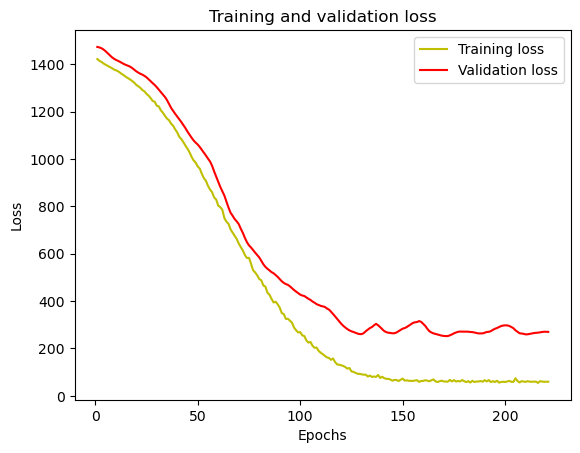

In [156]:
from matplotlib import pyplot as plt
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [73]:
model_save = model

In [176]:
from sklearn import metrics

nn_pred = model.predict(scaler_nn.transform(X_test_nn))


nn_MSE = metrics.mean_squared_error(y_nn_test, nn_pred)
nn_MAE = metrics.mean_absolute_error(y_nn_test, nn_pred)
nn_MAPE = metrics.mean_absolute_percentage_error(y_nn_test, nn_pred)
nn_accuracy = 100-(nn_MAPE*100)

print('MSE', nn_MSE )
print('MAE', nn_MAE)
print('MAPE', nn_MAPE)
print('Accuracy', nn_accuracy)

3/3 [==============================] - 0s 5ms/step
MSE 167.669485709813
MAE 4.733918434776132
MAPE 6457672404834708.0
Accuracy -6.457672404834707e+17


In [177]:
model.save('167__4_7.h5')

In [178]:
succ = load_model('167__4_7.h5')
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_162 (Dense)           (None, 34)                1190      
                                                                 
 leaky_re_lu_139 (LeakyReLU)  (None, 34)               0         
                                                                 
 batch_normalization_139 (Ba  (None, 34)               136       
 tchNormalization)                                               
                                                                 
 dense_163 (Dense)           (None, 68)                2380      
                                                                 
 leaky_re_lu_140 (LeakyReLU)  (None, 68)               0         
                                                                 
 batch_normalization_140 (Ba  (None, 68)               272       
 tchNormalization)                                   

In [64]:
my_data = [[53, 41.72, 3.35]]
# my_data_scaled = ss.transform(my_data)
def predict_with_ensemble(input_features, models, neural_net, scalers):
    # Initialize an empty array to hold the predictions from the small models
    X_nn = np.zeros((1, len(models)))

    # Reshape the input_features into 2D array suitable for the models' predict method
    input_features = np.array(input_features).reshape(1, -1)

    # Iterate over the small models
    for i, (name, model) in enumerate(models.items()):
        # Scale the input features
        input_features_scaled = scalers[name].transform(input_features)
        # Make a prediction with the current model and store it
        X_nn[0, i] = model.predict(input_features_scaled)

    # Feed the predictions from the small models into the neural network to get the final prediction
    final_prediction = neural_net.predict(X_nn)
    
    return final_prediction

output = predict_with_ensemble(my_data, models, model, scalers)

pd.set_option('display.max_columns', None)
output_df = pd.DataFrame(output, columns = y_colnames)
output_df

c:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature

1/1 [==============================] - 0s 23ms/step


c:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature

,Epidian 6D,Araldite GY260,Araldite GY250CH,CHS-520 (*CHS-530),CHS-525,CHS-590,Epidian 5,Epidian 6,Epilox AF 18-50,AH-24/Grilonit epoxide 8,Epidian 011,RD-3,RD-20,IPOX ER 1010,IPOX ER 1016,Cardura E,Benzilalkohol,EEW,TETA/ TEPA (a),IPDA,Jeffamine D230,Jeffamine D230 + Epilox1700,Jeffamine D230 + Epilox1700 (addukt 2),IPDA+1010 addukt,TEA/,Dytek A-MPMD/APU-2**,APU-4,trisDMP,DCH-99,MXDA,Ethacure 100,nonilfenol,etanol,AHEW
0,15.85743,-0.005496,0.001476,0.007231,0.002448,-0.002868,0.000114,0.005181,50.137161,17.936838,-0.004866,-0.006183,0.003067,1.78445,-0.103651,-0.00025,0.010534,187.310211,38.1278,-0.0031,3.77443,18.127014,0.011973,0.001905,16.205208,-0.000051,0.004751,0.001481,0.000596,0.013779,0.003909,-0.002741,-0.00267,44.655743


In [169]:
def predict_with_ensemble(input_features, models, neural_net, scalers, results_df):
    # Initialize an empty array to hold the predictions from the small models
    X_nn = np.zeros((1, len(models)))

    # Reshape the input_features into 2D array suitable for the models' predict method
    input_features = np.array(input_features).reshape(1, -1)

    # Initialize an empty DataFrame to hold the prediction intervals
    pred_intervals = pd.DataFrame(columns=["Lower Bound", "Upper Bound"], index=results_df["column"])

    # Iterate over the small models
    for i, (name, model) in enumerate(models.items()):
        # Scale the input features
        input_features_scaled = scalers[name].transform(input_features)
        # Make a prediction with the current model and store it
        prediction = model.predict(input_features_scaled)
        X_nn[0, i] = prediction

        # Compute the prediction interval
        test_mae = results_df.loc[results_df["column"] == name, "test_mae"].values[0]
        lower_bound = prediction - test_mae
        upper_bound = prediction + test_mae
        pred_intervals.loc[name] = [lower_bound[0], upper_bound[0]]

    # Feed the predictions from the small models into the neural network to get the final prediction
    final_prediction = neural_net.predict(X_nn)
    
    return final_prediction, pred_intervals

my_data = [[25, 50.9, 8.11]]
output, output_range = predict_with_ensemble(my_data, models, model_save, scalers, results_df)

pd.set_option('display.max_columns', None)


c:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature

1/1 [==============================] - 0s 23ms/step


c:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature

In [171]:
output_range

,Lower Bound,Upper Bound
column,,
Epidian 6D,13.687671,19.112329
Araldite GY260,-3.765312,3.765312
Araldite GY250CH,-3.871897,3.871897
CHS-520 (*CHS-530),-6.757445,7.958744
CHS-525,-1.148311,3.548311
CHS-590,-0.144154,0.144154
Epidian 5,-0.570012,2.036679
Epidian 6,-2.244737,2.244737
Epilox AF 18-50,21.337162,41.328553


In [172]:
output_df = pd.DataFrame(output, columns = y_colnames)
output_df


,Epidian 6D,Araldite GY260,Araldite GY250CH,CHS-520 (*CHS-530),CHS-525,CHS-590,Epidian 5,Epidian 6,Epilox AF 18-50,AH-24/Grilonit epoxide 8,Epidian 011,RD-3,RD-20,IPOX ER 1010,IPOX ER 1016,Cardura E,Benzilalkohol,EEW,TETA/ TEPA (a),IPDA,Jeffamine D230,Jeffamine D230 + Epilox1700,Jeffamine D230 + Epilox1700 (addukt 2),IPDA+1010 addukt,TEA/,Dytek A-MPMD/APU-2**,APU-4,trisDMP,DCH-99,MXDA,Ethacure 100,nonilfenol,etanol,AHEW
0,12.805858,-0.006433,0.001236,0.008368,0.001659,-0.004022,-0.000905,0.005164,40.800121,15.130173,-0.005547,0.637069,0.005393,11.412563,0.051865,-0.001743,0.010842,185.222229,41.304314,-0.008116,2.10012,20.988895,0.01151,0.001319,15.782487,0.001277,0.006857,0.000685,0.00123,0.008314,0.003739,-0.002528,-0.002249,43.596565


In [66]:
import pickle

# Save models
with open('models.pkl', 'wb') as f:
    pickle.dump(models, f)

# Save scalers
with open('scalers.pkl', 'wb') as f:
    pickle.dump(scalers, f)

# Save neural network
model.save('neural_network.h5')  # assuming 'model' is your neural network model (Keras model can be directly saved as .h5)

# Save results_df
results_df.to_pickle('results_df.pkl')  # pandas DataFrames have a built-in method for this


In [71]:
scalers

{'Epidian 6D': StandardScaler(),
 'Araldite GY260': StandardScaler(),
 'Araldite GY250CH': StandardScaler(),
 'CHS-520 (*CHS-530)': StandardScaler(),
 'CHS-525': StandardScaler(),
 'CHS-590': StandardScaler(),
 'Epidian 5': StandardScaler(),
 'Epidian 6': StandardScaler(),
 'Epilox AF 18-50': StandardScaler(),
 'AH-24/Grilonit epoxide 8': StandardScaler(),
 'Epidian 011': StandardScaler(),
 'RD-3': StandardScaler(),
 'RD-20': StandardScaler(),
 'IPOX ER 1010': StandardScaler(),
 'IPOX ER 1016': StandardScaler(),
 'Cardura E': StandardScaler(),
 'Benzilalkohol': StandardScaler(),
 'EEW': StandardScaler(),
 'TETA/         TEPA (a)': StandardScaler(),
 'IPDA': StandardScaler(),
 'Jeffamine D230': StandardScaler(),
 'Jeffamine D230 + Epilox1700': StandardScaler(),
 'Jeffamine D230 + Epilox1700 (addukt 2)': StandardScaler(),
 'IPDA+1010 addukt': StandardScaler(),
 'TEA/ ': StandardScaler(),
 'Dytek A-MPMD/APU-2**': StandardScaler(),
 'APU-4': StandardScaler(),
 'trisDMP': StandardScaler(),


In [68]:
import pickle
from tensorflow.keras.models import load_model
import pandas as pd

# Load models
with open('models.pkl', 'rb') as f:
    loaded_models = pickle.load(f)

# Load scalers
with open('scalers.pkl', 'rb') as f:
    loaded_scalers = pickle.load(f)

# Load neural network
loaded_model = load_model('neural_network.h5')
# Load results_df
loaded_results_df = pd.read_pickle('results_df.pkl')


def predict_with_ensemble(input_features, models, neural_net, scalers, results_df):
    # Initialize an empty array to hold the predictions from the small models
    X_nn = np.zeros((1, len(models)))

    # Reshape the input_features into 2D array suitable for the models' predict method
    input_features = np.array(input_features).reshape(1, -1)

    # Initialize an empty DataFrame to hold the prediction intervals
    pred_intervals = pd.DataFrame(columns=["Lower Bound", "Upper Bound"], index=results_df["column"])

    # Iterate over the small models
    for i, (name, model) in enumerate(models.items()):
        # Scale the input features
        input_features_scaled = scalers[name].transform(input_features)
        # Make a prediction with the current model and store it
        prediction = model.predict(input_features_scaled)
        X_nn[0, i] = prediction

        # Compute the prediction interval
        test_mae = results_df.loc[results_df["column"] == name, "test_mae"].values[0]
        lower_bound = prediction - test_mae
        upper_bound = prediction + test_mae
        pred_intervals.loc[name] = [lower_bound[0], upper_bound[0]]

    # Feed the predictions from the small models into the neural network to get the final prediction
    final_prediction = neural_net.predict(X_nn)
    
    return final_prediction, pred_intervals

my_data = [[34, 56.6, 4.76]]
output, output_range = predict_with_ensemble(my_data, loaded_models, loaded_model, loaded_scalers, loaded_results_df)

pd.set_option('display.max_columns', None)
output_df = pd.DataFrame(output, columns = y_colnames)
output_df
output_range

ValueError: The last dimension of the inputs to a Dense layer should be defined. Found None. Full input shape received: (None, None)

In [129]:
asd = load_model('scaled_nn.h5')
asd.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_89 (Dense)            (None, 34)                1190      
                                                                 
 leaky_re_lu_77 (LeakyReLU)  (None, 34)                0         
                                                                 
 batch_normalization_77 (Bat  (None, 34)               136       
 chNormalization)                                                
                                                                 
 dense_90 (Dense)            (None, 8)                 280       
                                                                 
 leaky_re_lu_78 (LeakyReLU)  (None, 8)                 0         
                                                                 
 batch_normalization_78 (Bat  (None, 8)                32        
 chNormalization)                                    

In [82]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 3)                 105       
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 3)                 0         
                                                                 
 batch_normalization_12 (Bat  (None, 3)                12        
 chNormalization)                                                
                                                                 
 dense_15 (Dense)            (None, 6)                 24        
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 6)                 0         
                                                                 
 batch_normalization_13 (Bat  (None, 6)                24        
 chNormalization)                                     

In [80]:
model.save('nn1.keras')


In [83]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization

model = load_model('neural_network.h5', 
                   custom_objects={'LeakyReLU': LeakyReLU, 'BatchNormalization': BatchNormalization})

asd = load_model('nn1.keras')
asd.summary()

ValueError: The last dimension of the inputs to a Dense layer should be defined. Found None. Full input shape received: (None, None)